In [13]:
from __future__ import print_function
import time, os, json
import tensorflow as tf
import pickle
import os
import numpy as np
import logging
import matplotlib.pyplot as plt

from util import *
from model.video_caption import sequence_2_sequence_LSTM
from model.image_caption import image_caption_LSTM

from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Build Model

In [16]:
#=======Change These===============================
max_train = 7000
word_vector_size = 50
#==================================================


data = load_coco_data(pca_features = False, max_train = max_train)
input_size = data['train_features'].shape[1]
maxLen = data['train_captions'].shape[1]
wordLs = []

for caption in data['train_captions']:
    for word in caption:
        wordLs.append(word)
voc_size = len(list(set(wordLs)))

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))
print('\ninput_size:', input_size, ' maxLen:', maxLen, ' voc_size:', voc_size)
print('Finish loading training data!')

val_image_idxs <class 'numpy.ndarray'> (195954,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
train_image_idxs <class 'numpy.ndarray'> (7000,) int32
idx_to_word <class 'list'> 1004
val_urls <class 'numpy.ndarray'> (40504,) <U63
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
train_features <class 'numpy.ndarray'> (82783, 4096) float32
val_features <class 'numpy.ndarray'> (40504, 4096) float32
train_captions <class 'numpy.ndarray'> (7000, 17) int32

input_size: 4096  maxLen: 17  voc_size: 1004
Finish loading training data!


In [17]:
curPath = os.getcwd()
dataPath = curPath + "/datasets/"

# pick first 100 for debugging purpose
# load data
sample_size = 4000
wvector_dim = 50
is_training = True
_, _, word_dict, word2Index, index2Word = load_caption_data(sample_size, dataPath, train = is_training)

In [18]:
# create word2ind and ind2word dictionary
index2Word_ori = data['idx_to_word']
word2Index_ori = data['word_to_idx']

wordLs = sorted(list(set(wordLs)))
word2Index_coco = {}
index2Word_coco = {}
for i, word_ind in enumerate(wordLs):
    word = index2Word_ori[word_ind]
    word2Index_coco[word] = i
    index2Word_coco[i] = word
print('finish building dictionary')

finish building dictionary


build model

In [98]:
captions_train = {}
captions_corresponding_videoIds = []
input_frames_train = {}

count = 0
captions_corresponding_videoIds = data['train_image_idxs']
word_unk_ls = []
word_ls = []
for i, ind in enumerate(data['train_image_idxs']):
    caption = data['train_captions'][i]
    caption_new = []
    for word_ind in caption:
        word = index2Word_coco[word_ind]
        word_ls.append(word)
        index_new = word2Index['<unk>']
        if word in word2Index:
            index_new = word2Index[word]  
        else:
            word_unk_ls.append(word)
            count += 1
            
        caption_new.append( index_new )
        
    captions_train[i] = list(caption_new)
    input_frames_train[i] = data['train_features'][ind].reshape(1, input_size)
word_ls = np.unique(word_ls)
np.save('./datasets/CoCo_wordLs.npy', word_ls)

voc_size = 6169
word_embedding = word_embedding_array(word_dict, word_vector_size, word2Index)
# word_embedding = np.random.randn(voc_size, word_vector_size).astype(np.float32)

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

In [30]:
print(np.unique(word_unk_ls))

['<NULL>' '<UNK>' 'airplanes' 'antique' 'appliances' 'asian' 'assorted'
 'assortment' 'atop' 'bananas' 'bathtub' 'batter' 'bicycles' 'bikes'
 'blender' 'blurry' 'boarder' 'brick' 'bun' 'buses' 'bushes' 'cabinets'
 'cakes' 'candles' 'carrots' 'catcher' 'cattle' 'cellphone' 'cement'
 'clock' 'clocks' 'closeup' 'cluttered' 'colorful' 'commuter' 'containers'
 'controller' 'controllers' 'cute' 'decker' 'dock' 'docked' 'donut'
 'donuts' 'doorway' 'doughnut' 'doughnuts' 'eaten' 'fenced' 'flock'
 'foreground' 'fries' 'frisbee' 'giraffe' 'graze' 'grill' 'guys' 'hay'
 'herd' 'hillside' 'hotdog' 'hydrant' 'intersection' 'kids' 'kites'
 'kneeling' 'landing' 'laptop' 'laptops' 'leash' 'lettuce' 'mans' 'messy'
 'meter' 'monitors' 'nintendo' 'oranges' 'outdoors' 'pants' 'papers'
 'parked' 'pasta' 'pastries' 'pastry' 'pasture' 'pedestrians' 'pepperoni'
 'peppers' 'perched' 'phones' 'photos' 'pillows' 'pizza' 'pizzas' 'poles'
 'posing' 'post' 'racket' 'rackets' 'racquet' 'rail' 'railroad' 'ramp'
 'refl

In [20]:
# define parameters
logging.basicConfig(level=logging.INFO)
#=======Change These===============================
state_size = 512
#==================================================

tf.app.flags.DEFINE_string("model_name", "sequence2sequence", "name of the model")
tf.app.flags.DEFINE_integer("state_size", state_size, "Size of each model layer.")
tf.app.flags.DEFINE_float("input_size", 4096, "input size for each frame")
tf.app.flags.DEFINE_integer("max_sentence_length", 17, "maximum captioning sentence length")
tf.app.flags.DEFINE_integer("word_vector_size", word_vector_size, "word embedding dimension default is 25 for twitter glove")
tf.app.flags.DEFINE_integer("num_frames", 1, "number of frames per video")
#tf.app.flags.DEFINE_integer("voc_size", 6169, "number of vocabulary")
FLAGS = tf.app.flags.FLAGS        

In [21]:
# build model graph
tf.reset_default_graph()
#=======Change These===============================
batch_size = 64
epoch = 20
lr = 1e-4
hidden_size = 512
#==================================================

model = image_caption_LSTM(word_embedding, FLAGS, batch_size=batch_size, hidden_size=hidden_size,
        voc_size = voc_size, n_epochs = epoch, lr = lr, reg = 1e-4, save_model_file = 'bestModel')

# model = sequence_2_sequence_LSTM(word_embedding, FLAGS, batch_size=batch_size, hidden_size=hidden_size,
#         voc_size = voc_size, n_epochs = epoch, lr = lr, reg = 1e-3, mode = 'train', save_model_file = 'COCO')

model.train_embedding = False
model.build()

start building model ...
total number of parameter 13763097


In [ ]:
# check variables
for v in tf.trainable_variables():
    print(v)

In [ ]:
# run training mode
with get_session() as sess:
    saver = tf.train.Saver()
#     saver.restore(sess, os.getcwd() + "/model/bestModel.ckpt")
#     saver.restore(sess, os.getcwd() + "/model/lastestModel.ckpt")
    sess.run(tf.global_variables_initializer())
    out = model.train(sess, (input_frames_train, captions_train), verbose = True)

400000
320000
 220/5000 [>.............................] - ETA: 1322s - train loss: 4.2887

In [ ]:
val_loss, tr_loss, tr_pred, val_pred, train_vid, val_vid = out

In [ ]:
# plot learning curve
plt.plot(range(len(tr_loss)), tr_loss, 'r-', linewidth = 2, label = 'train')
plt.plot(range(len(val_loss)), val_loss, 'b-', linewidth = 2, label = 'validation')
plt.grid()
plt.xlabel('iteration', fontsize = 13)
plt.ylabel('loss', fontsize = 13)
plt.title('iteration vs loss', fontsize = 15)
plt.legend()
plt.savefig(os.getcwd() + '/output/CoCo_image_caption_learning_curve.png')
# plt.savefig(os.getcwd() + '/output/CoCo_seq2seq_learning_curve.png')

In [ ]:
# list_video_index, list_predict_index = out

captions = captions_train
train_urls = data['train_urls']
# caption check
for j in range(len(val_pred)):
    words = []
    trues = []
    sample = val_pred[j]
    vid = val_vid[j]
    cap = captions[vid]
    for idx, i in enumerate(sample):
        word = index2Word[i]
        true = index2Word[cap[idx]]
        
        if word not in ['<NULL>']:
            words.append(word)
        if true not in ['<NULL>']:
            trues.append(true) 
        
    if j<3: 
        url = train_urls[int(vid)]
        plt.imshow(image_from_url(url))
        plt.axis('off')
        plt.show()
    print(vid)
    print('Pred Caption: ', ' '.join(w for w in words))
    print('True Caption: ', ' '.join(t for t in trues))
    print('-'*50)

# TestSet

val_features....\class 'numpy.ndarray'\....   (40504, 4096) float32  
val_captions....\class 'numpy.ndarray'\....   (195954, 17) int32   
val_image_idxs....\<class 'numpy.ndarray'\....   (195954,) int32   
val_urls class....\'numpy.ndarray'\....   (40504,) <U63   

train_features....\class 'numpy.ndarray'\....   (82783, 4096) float32    
train_captions....\class 'numpy.ndarray'\....   (1000, 17) int32   
train_image_idxs....\class 'numpy.ndarray'\....   (1000,) int32   
train_urls....\class 'numpy.ndarray'\....   (82783,) <U63      

idx_to_word....\class 'list'\....   1004   
word_to_idx....\class 'dict'\....   1004   


In [61]:
# create word2ind and ind2word dictionary
index2Word_ori = data['idx_to_word']
word2Index_ori = data['word_to_idx']

wordLs = sorted(list(set(wordLs)))
word2Index_coco = {}
index2Word_coco = {}
for i, word_ind in enumerate(wordLs):
    word = index2Word_ori[word_ind]
    word2Index_coco[word] = i
    index2Word_coco[i] = word
print('finish building dictionary')

finish building dictionary


In [80]:
val_features = data['val_features']
val_captions = data['val_captions']
val_image_idxs = data['val_image_idxs']
val_urls = data['val_urls']

# Extract test set 
n = 20
val_features_dict = {}
val_captions_dict = {}
val_urls_dict = {}
val_image_idxs_dict = {}

count = 0
for t in range(len(val_image_idxs)):
    i = np.random.choice(list(range(195954)))
    vid = val_image_idxs[i]
    
    if vid >= len(val_features): continue
    count += 1
    if count>=n: break
    
    captions_gloveId = []
    for ind in val_captions[i]:
        word = index2Word_coco[ind]
        index_new = word2Index['<unk>']
        if word in word2Index:
            index_new = word2Index[word]  
        captions_gloveId.append(index_new)    
    
    
    val_captions_dict[count] = list(captions_gloveId)
    val_features_dict[count] = val_features[vid].reshape((1,-1))
    val_urls_dict[count] = val_urls[vid]
    val_image_idxs_dict[count] = val_image_idxs[i]

# Predict testset

In [82]:
with get_session() as sess:
    saver = tf.train.Saver()
#     saver.restore(sess, os.getcwd() + "/model/bestModel.ckpt")
    saver.restore(sess, os.getcwd() + "/model/lastestModel.ckpt")
    out = model.predict(sess, val_features_dict, val_captions_dict)

INFO:tensorflow:Restoring parameters from /home/sunjiajun/cs231n_project/model/lastestModel.ckpt


INFO:tensorflow:Restoring parameters from /home/sunjiajun/cs231n_project/model/lastestModel.ckpt
100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


In [83]:
list_video_index, list_predict_index = out

1


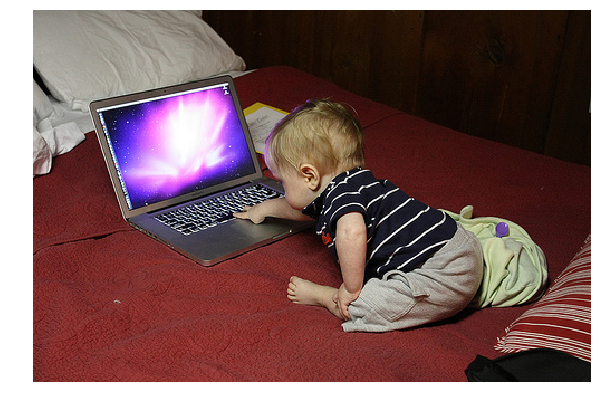

Pred Caption:  <START> a cat laying on a a a a a <unk> <unk> <unk> <unk> <unk> <unk> <unk>
true Caption:  <START> a baby <unk> a <unk> on a <unk> <END>
--------------------------------------------------
2


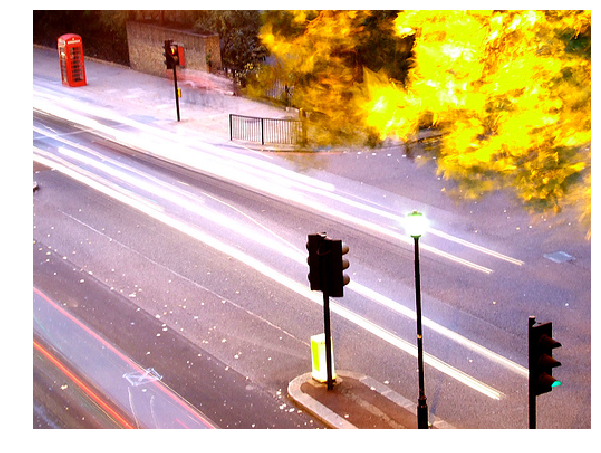

Pred Caption:  <START> a <unk> <unk> a a a a a a <unk> <unk> <unk> <unk> <unk> <unk> <unk>
true Caption:  <START> a building <unk> of <unk> sitting on the side of a street <END>
--------------------------------------------------
3


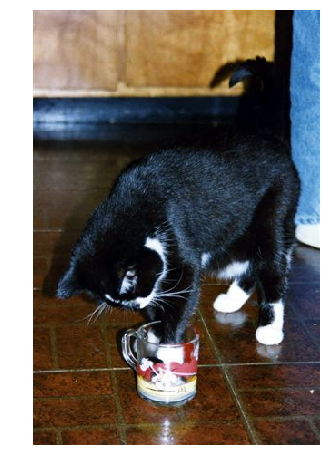

Pred Caption:  <START> a black and white a a a <unk> <END>
true Caption:  <START> a black and white cat putting its <unk> in a cup on a <unk> floor <END>
--------------------------------------------------
4


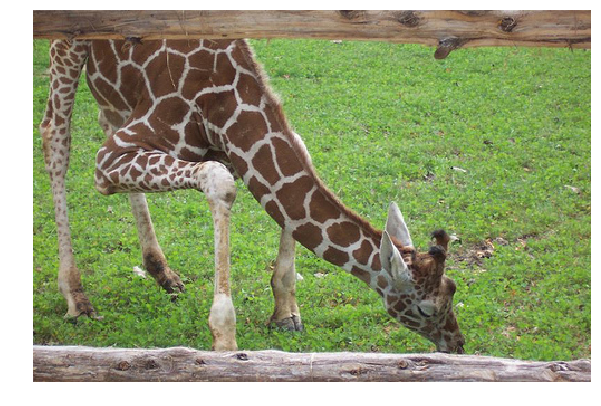

Pred Caption:  <START> a <unk> <unk> in a a a <unk> <END>
true Caption:  <START> a large <unk> walking across a lush green field <END>
--------------------------------------------------
5


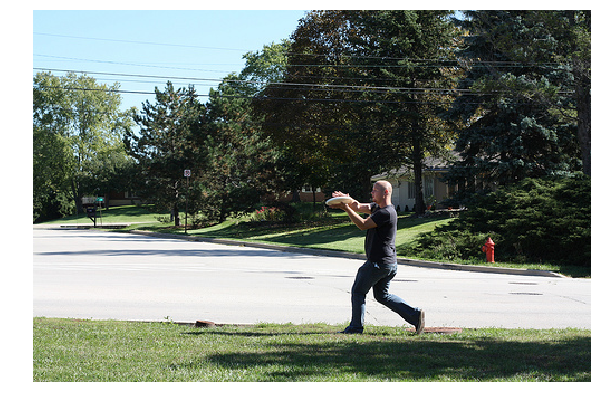

Pred Caption:  <START> a man is a a <unk> a a <END>
true Caption:  <START> a man <unk> <unk> to catch a <unk> <END>
--------------------------------------------------
6


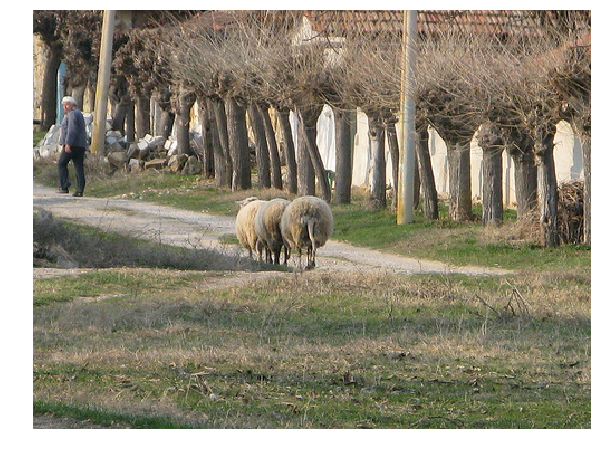

Pred Caption:  <START> a <unk> of <unk> a in a a <END>
true Caption:  <START> three sheep walking together <unk> a trail <END>
--------------------------------------------------
7


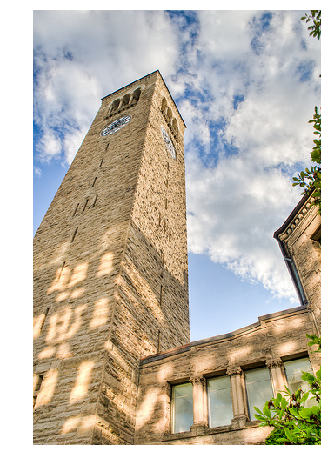

Pred Caption:  <START> a <unk> tower <unk> <unk> <unk> a <unk> <END>
true Caption:  <START> tall stone tower building and beautiful blue sky <END>
--------------------------------------------------
8


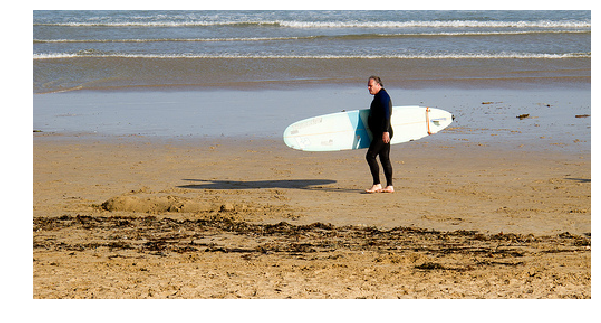

Pred Caption:  <START> a woman <unk> a a beach a beach beach <END>
true Caption:  <START> a man walking on the beach carrying a surfboard <END>
--------------------------------------------------
9


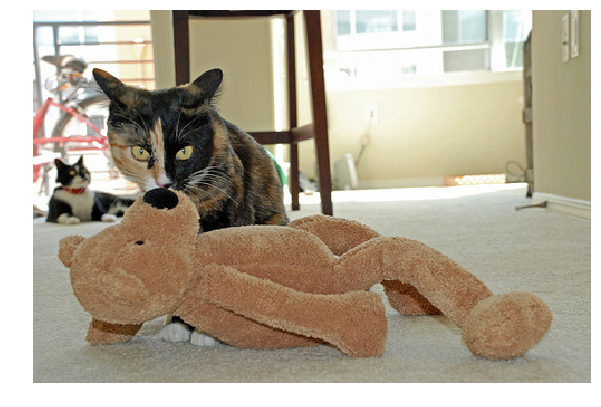

Pred Caption:  <START> a brown bear is a a a a a <END>
true Caption:  <START> a <unk> cat <unk> a brown teddy bear <END>
--------------------------------------------------
10


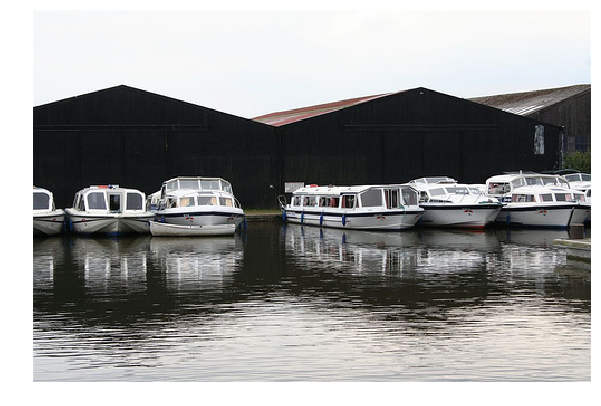

Pred Caption:  <START> a <unk> of <unk> <unk> <unk> <unk> <unk> <END>
true Caption:  <START> the photo shows several boats are <unk> in the <unk> <END>
--------------------------------------------------
11


Pred Caption:  <START> a black bear sitting sitting a a a a <END>
true Caption:  <START> <unk> near white shower curtain in <unk> bathroom setting <END>
--------------------------------------------------
12


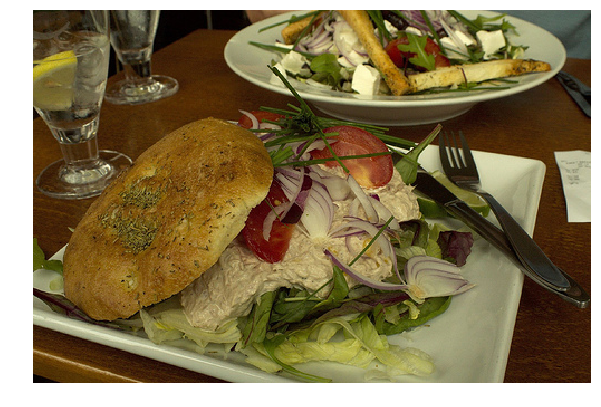

Pred Caption:  <START> a sandwich with with <unk> <unk> <unk> <unk> <END>
true Caption:  <START> a sandwich on a white plate with a knife and fork <END>
--------------------------------------------------
13


Pred Caption:  <START> two man playing a <unk> <unk> a a <END>
true Caption:  <START> two people playing <unk> in a field <END>
--------------------------------------------------
14


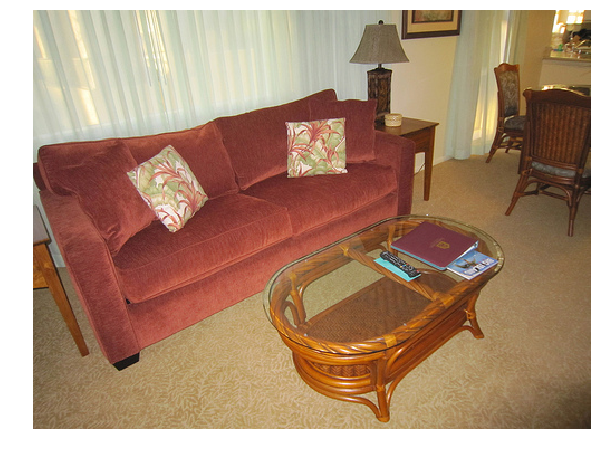

Pred Caption:  <START> a <unk> room with <unk> <unk> and <unk> <END>
true Caption:  <START> living room with sofa coffee table chair and end table <END>
--------------------------------------------------
15


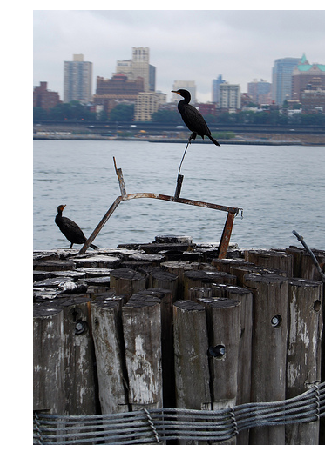

Pred Caption:  <START> a man riding a a a a a <END>
true Caption:  <START> birds <unk> on some wood by an <unk> of water <END>
--------------------------------------------------
16


Pred Caption:  <START> a <unk> with a a <unk> <unk> <unk> <END>
true Caption:  <START> a small bathroom with a shower curtain with the <unk> <unk> <unk> on it <END>
--------------------------------------------------
17


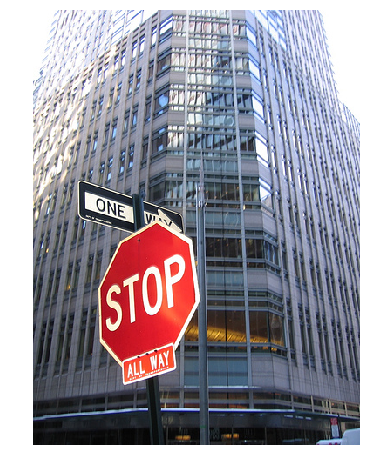

Pred Caption:  <START> a sign sign <unk> a <unk> a <unk> <END>
true Caption:  <START> a stop sign and one way sign are in front of a large building <END>
--------------------------------------------------
18


Pred Caption:  <START> a <unk> with with a a a <unk> <END>
true Caption:  <START> a group of vases holding flowers sitting on a stove top <END>
--------------------------------------------------
19


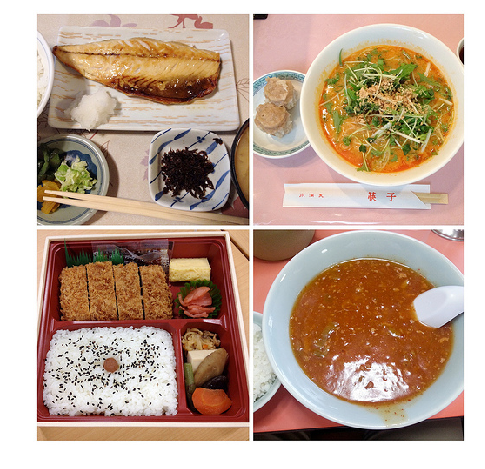

Pred Caption:  <START> a <unk> of with <unk> <unk> and <unk> <END>
true Caption:  <START> a <unk> with pictures of different types of food <END>
--------------------------------------------------


In [86]:
for i, vid in enumerate( list_video_index ):
    print(vid)
    v_id = val_image_idxs_dict[vid]
    url = val_urls_dict[vid]
    
    
    caption_pre = []
    for ind in list_predict_index[0][i]:
        word = index2Word[ind]       
        if word not in ['<NULL>']:
            caption_pre.append(word)
        if word == '<END>': break
            
    caption_true = []
    for ind in val_captions_dict[vid]:
        word = index2Word[ind]       
        if word not in ['<NULL>']:
            caption_true.append(word)
        if word == '<END>': break  
            
    plt.imshow(image_from_url(url))
    plt.axis('off')
    plt.show()
    print('Pred Caption: ', ' '.join(w for w in caption_pre))
    print('true Caption: ', ' '.join(w for w in caption_true))
    print('-'*50)

In [ ]:
vid = 10

url = data['train_urls'][vid]
plt.imshow(image_from_url(url))
plt.axis('off')
plt.show()



words = []
for ind in captions_train[vid]:
    word = index2Word[ind]
    words.append(word)
print(" ".join(words))